# CM20219 – Convolution Lab
This lab implements image convolution of greyscale images and is worth 3.3% of marks for the unit.

Convolution a basic image filtering operation that is implemented in:
* many computer vision systems (e.g. for edge detection),
* most image editing programs such as Photoshop (e.g. for image sharpening), and
* many deep learning systems, e.g. for convolutional neural networks (CNNs).

Let us start by preparing the notebook, and loading and preparing a test image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy, scipy.misc, scipy.ndimage, scipy.fftpack # ndimage = multi-dimensional image processing
import scipy.signal
import math


In [2]:
## Make figures larger
plt.rcParams['figure.figsize'] = [10, 6]

## Try commenting this out if plots look blurry on your screen.
# %config InlineBackend.figure_format = 'retina'

'image_int' has shape (512, 512) and datatype int32


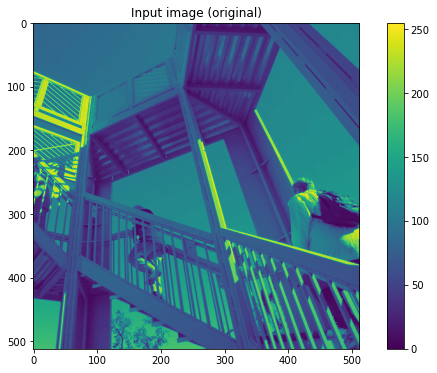

In [3]:
## Load a built-in test image.
image_int = scipy.misc.ascent() # obtain 8 bit 512 x 512 test image 
print(f"'image_int' has shape {image_int.shape} and datatype {image_int.dtype}")

## Display the input image.
## Note that Matplotlib by default uses a colour map for single-channel images.
## The colour map is illustrated using the colour bar on the right.
plt.imshow(image_int)
plt.title('Input image (original)')
plt.colorbar();  # The semicolon suppresses the return value of the function.

'image' has shape (512, 512) and datatype float64


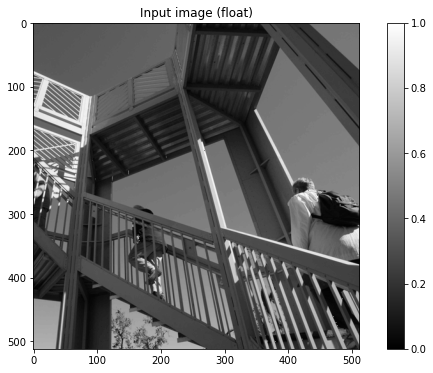

In [4]:
## Convert the image from integer 0..255 to float 0..1 for easier processing.
image = image_int.astype('float') / 255
print(f"'image' has shape {image.shape} and datatype {image.dtype}")

## Here, we override the default colour map using 'gray[scale]',
## and set the range of displayed values to vmin..vmax = 0..1.
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.title('Input image (float)')
plt.colorbar();

'image_crop' has shape (100, 100) and datatype float64


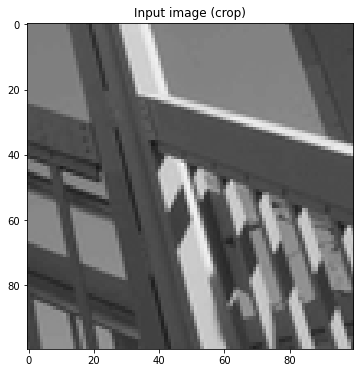

In [5]:
## Lets us crop out a subimage as a test image.
image_crop = image[300:400, 260:360]
print(f"'image_crop' has shape {image_crop.shape} and datatype {image_crop.dtype}")

## Display the image.
plt.imshow(image_crop, cmap='gray', vmin=0, vmax=1)
plt.title('Input image (crop)');

----
## 1. Basic convolution [40 marks]

Implement basic convolution by translating the pseudo-code below to Python.

Fill in the `basic_convolution(image, kernel)` below, which takes as input a grayscale `image` (2D matrix) and a filtering `kernel` (2D matrix), and returns the convolved image result as a greyscale image with the same size and datatype as the input image.

This operation can be described by the following pseudocode:
```
for each image row in input image:
    for each pixel in image row:
        set accumulator to zero
        
        for each kernel row in kernel:
            for each element in kernel row:
                if element position <corresponding to> pixel position then
                    multiply element value <corresponding to> pixel value
                    add result to accumulator
                endif

        set output image pixel to accumulator
```
(`<corresponding to>` input image pixels are found relative to the kernel’s origin)

Source: https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution

In [6]:
def basic_convolution(image, kernel, verbose=False):
    imageC = image.copy()
    radius_y = math.floor(kernel.shape[0] / 2)
    radius_x = math.floor(kernel.shape[1] / 2)
    imagePad = np.pad(imageC, ((radius_y,),(radius_x,)), constant_values = (0,0))
    kernel = np.flip(kernel)
    for row in range(radius_y, imagePad.shape[0] - radius_y):
        for pixel in range(radius_x, imagePad.shape[1] - radius_x):
            acc = 0 
            for i in range(kernel.shape[0]):
                for j in range(kernel.shape[1]): 
                    acc += kernel[i][j] * imagePad[(row - radius_y) + i ][(pixel - radius_x) + j]
            imageC[row-radius_y][pixel-radius_x] = acc
    return imageC


    

### Test your result

Demonstrate the functionality of your function by running the following cell.
Does you result looked blurry?

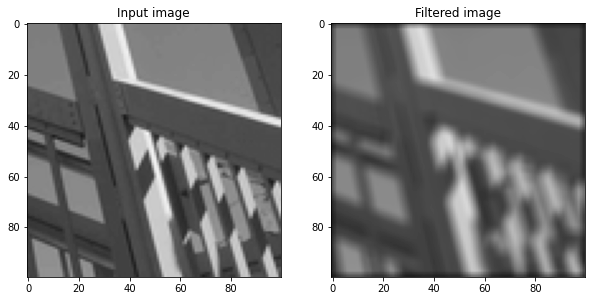

In [7]:
## Prepare a small convolution kernel (good for basic convolution).
kernel = np.ones([5,5])
kernel = kernel / kernel.sum()  # normalise kernel

result = basic_convolution(image_crop, kernel)
## Display input image on the left.
plt.subplot(1, 2, 1); plt.title('Input image'); plt.imshow(image_crop, cmap='gray', vmin=0, vmax=1)

## Display filtered image on the right.
plt.subplot(1, 2, 2); plt.title('Filtered image'); plt.imshow(result, cmap='gray', vmin=0, vmax=1);




----
## 2.	Border handling [20 marks]

Improve your implementation from the previous exercise:
1. Centre the filtered image, so that the content of the input and filtered images is not shifted between them; and
2. Fill in the border regions by extending/replicating the edge pixels of the image (‘clamp-to-edge’).

In [8]:
def extended_convolution(image, kernel, verbose=False):
    imageC = image.copy()
    radius_y = math.floor(kernel.shape[0] / 2)
    radius_x = math.floor(kernel.shape[1] / 2)
    imagePad = np.pad(imageC, ((radius_y,), (radius_x,)), mode= "edge")
    kernel = np.flip(kernel)
    for row in range(radius_y, imagePad.shape[0] - radius_y):
        for pixel in range(radius_x, imagePad.shape[1] - radius_x):
            acc = 0 
            for i in range(kernel.shape[0]):
                for j in range(kernel.shape[1]):
                    acc += kernel[i][j] * imagePad[(row - radius_y) + i ][(pixel - radius_x) + j]
            imageC[row-radius_y][pixel-radius_x] = acc
    return imageC
                               

### Test your result

A perfect result will match SciPy’s function `convolve` (with `mode='nearest'`) exactly, i.e. with a sum of squared differences (SSD) of 0 (zero):

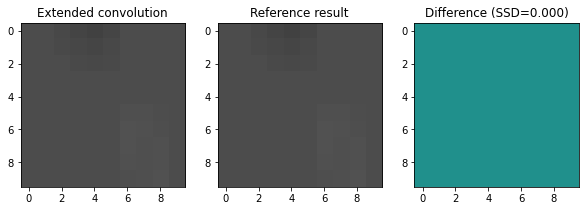

In [9]:
kernel = np.random.rand(5,3)
kernel = kernel / kernel.sum()  # normalise kernel
imageTest = np.round(image_crop[20:30, 20:30],1)


filtered = extended_convolution(imageTest, kernel)
reference = scipy.ndimage.convolve(imageTest, kernel, mode = "nearest")


ssd = np.sum(np.power(filtered - reference, 2))

plt.subplot(1, 3, 1); plt.title('Extended convolution');        plt.imshow(filtered,  cmap='gray', vmin=0,  vmax=1)
plt.subplot(1, 3, 2); plt.title('Reference result');            plt.imshow(reference, cmap='gray', vmin=0,  vmax=1)
plt.subplot(1, 3, 3); plt.title(f'Difference (SSD={ssd:.3f})'); plt.imshow(filtered - reference,   vmin=-1, vmax=1);

----
## 3. Image filtering [10 marks]

a) Design and demonstrate 3×3 convolution kernels for:
* computing horizontal, vertical and (any) diagonal image gradients, and
* sharpening an image using unsharp masking.

In [10]:
## TASK: edit the gradient kernels:

vgrad = np.array([[-1, -2, -1], 
                  [0,0 , 0],
                  [1,2,1]])  # vertical gradients

hgrad = np.array([[1, 0, -1],
                  [2, 0, -2], 
                  [1, 0, -1]])  # horizontal gradients

dgrad = np.array([[2, 1, 0],
                  [1, 0, -1],
                  [0, -1, -2]])  # diagonal gradients (any direction)

print("horizontal gradient kernel:"); print(hgrad); print()
print("vertical gradient kernel:");   print(vgrad); print()
print("diagonal gradient kernel:");   print(dgrad)

horizontal gradient kernel:
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]

vertical gradient kernel:
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]

diagonal gradient kernel:
[[ 2  1  0]
 [ 1  0 -1]
 [ 0 -1 -2]]


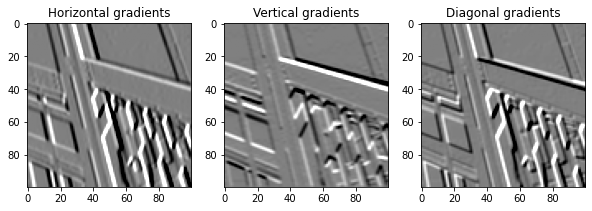

In [11]:
## Perform convolutions with the gradient kernels
hgrad_result = scipy.ndimage.convolve(image_crop, hgrad, mode='nearest')
vgrad_result = scipy.ndimage.convolve(image_crop, vgrad, mode='nearest')
dgrad_result = scipy.ndimage.convolve(image_crop, dgrad, mode='nearest')

## Show results
plt.subplot(1, 3, 1); plt.title('Horizontal gradients'); plt.imshow(hgrad_result, cmap='gray', vmin=-1, vmax=1)
plt.subplot(1, 3, 2); plt.title('Vertical gradients');   plt.imshow(vgrad_result, cmap='gray', vmin=-1, vmax=1)
plt.subplot(1, 3, 3); plt.title('Diagonal gradients');   plt.imshow(dgrad_result, cmap='gray', vmin=-1, vmax=1);

Unsharp masking kernel:
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]


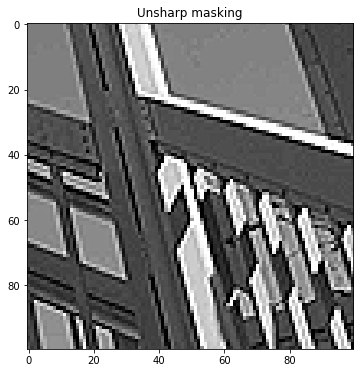

In [12]:
## TASK: unsharp masking kernel
usm = np.array([[0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]])

print("Unsharp masking kernel:"); print(usm)
usm_result = scipy.ndimage.convolve(image_crop, usm, mode='nearest')
plt.title('Unsharp masking'); plt.imshow(usm_result, cmap='gray', vmin=0, vmax=1);

b) Compute the kernel for a 5×5 Gaussian blur with a standard deviation of 1 pixel.
Make sure that the kernel is normalised.

Gaussian 5x5 kernel:
[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]

Sum of elements: 1.0


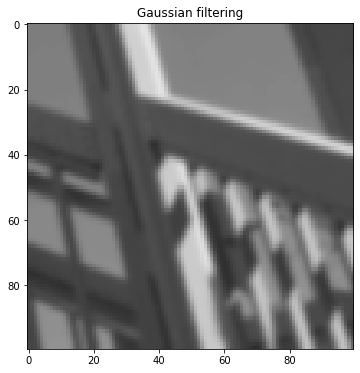

In [13]:
## TASK: 5x5 Gaussian kernel with standard deviation of 1 pixel
gauss = np.zeros([5, 5])
gauss[2, 2] = 1
std = 1

# generate equal space for the distribution from -2 to 2 for our size
# the mean will be the center value of this which is 0, and this is used as input with std to
# generate our distribution function for the row
row = np.linspace(-2,2, 5)

# calculate the density distribution for a row 
for i in range(5):
    row[i] = 1 / (np.sqrt(2 * np.pi) * std) * np.e ** (-np.power((row[i] - 0) / std, 2) / 2)

#generate the 2d blur filter , https://en.wikipedia.org/wiki/Outer_product
gauss = np.outer(row.T, row.T)

# normalise
gauss = gauss / gauss.sum()

print("Gaussian 5x5 kernel:"); print(gauss)
print(f"\nSum of elements: {gauss.sum()}")
gauss_result = scipy.ndimage.convolve(image_crop, gauss, mode='nearest')
plt.title('Gaussian filtering'); plt.imshow(gauss_result, cmap='gray', vmin=0, vmax=1);


----
## 4.	Exploiting the convolution theorem [30 marks]

Apply the convolution theorem to speed up the convolution.

You can use NumPy’s functions for 2D Fast Fourier Transform (FFT), `np.fft.fft2` and its inverse `np.fft.ifft2`.

In [128]:
def fft_convolution(image, kernel):
    imageC = image.copy()
    kSize = (kernel.size // 2)
    kernelShape = tuple(ti//2 for ti in kernel.shape)
    centery ,centerx = kernelShape
    imagePad = np.pad(image, kSize, mode = "edge")
    imageC = np.fft.fft2(imagePad)
    kernel= np.fft.fft2(kernel, imagePad.shape)
    output = np.real(np.fft.ifft2(np.multiply(imageC, kernel)))
    
    test = output[kSize+centery:-kSize+centery, kSize+centerx:-kSize+centerx]
    return test


def circExt(k, rows, cols):
    radiusV = np.floor(k.shape[0] / 2)
    radiusH = np.floor(k.shape[1] / 2)
  
    k_c = k

    k_c = np.pad(k_c,((0, int(rows-k.shape[0])), (0, int(cols-k.shape[1]))))

    k_c = np.roll(k_c, int(-radiusV), axis = 0)
    k_c = np.roll(k_c, int(-radiusH), axis = 1)
    
    return k_c
    

def testfft2(image, kernel):
    print(kernel)
    imageC = image.copy()
    kSize = (kernel.size // 2) + 1
    kernelShape = tuple(ti//2 for ti in kernel.shape)
    
    n_rows, n_cols = imageC.shape
    
    centery ,centerx = kernelShape
 
    imagePad = np.pad(imageC, ((centery, centery), (centerx, centerx)), mode = "edge")
    print(imagePad)
    kernelShift = circExt(kernel, imagePad.shape[0], imagePad.shape[1])   

    imageC = np.fft.fft2(imagePad)
    kernel= np.fft.fft2(kernelShift)
    output = np.real(np.fft.ifft2(np.multiply(imageC, kernel)))

    
    plt.subplot(1, 3, 1); 
    plt.title('Fast convolution');            
    plt.imshow(output[centerx:centerx + n_rows, centery: centery+ n_cols ],  cmap='gray', vmin=0,  vmax=1)
    
    return output[centerx:centerx + n_rows, centery: centery+ n_cols ]
    

### Test your result

A perfect result will match SciPy’s function `convolve` (with `mode='nearest'`) exactly, i.e. with a sum of squared differences (SSD) of 0 (zero):

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]
[[0.49019608 0.49019608 0.49019608 ... 0.27843137 0.27843137 0.27843137]
 [0.49019608 0.49019608 0.49019608 ... 0.27843137 0.27843137 0.27843137]
 [0.49019608 0.49019608 0.49019608 ... 0.2745098  0.2745098  0.2745098 ]
 ...
 [0.28627451 0.28627451 0.26666667 ... 0.61568627 0.30196078 0.30196078]
 [0.30196078 0.30196078 0.25882353 ... 0.7254902  0.29411765 0.29411765]
 [0.30196078 0.30196078 0.25882353 ... 0.7254902  0.29411765 0.29411765]]
(100, 100)


<ipython-input-129-cf332832af05>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 1); plt.title('Fast convolution');            plt.imshow(filtered,  cmap='gray', vmin=0,  vmax=1)


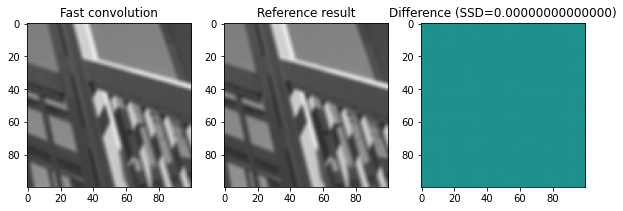

In [129]:
#kernel = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
kernel = np.ones((3,3))
kernel = kernel /kernel.sum()  # normalise kernel
#imageTest = np.ran kdom.randint(3, size=(10,10))
#imagePad = np.pad(imageTest, ((2,2),(3,3)), constant_values = -4)

imageCrop2 = image_crop[20:25, 20:25]
#imageCrop2 = np.random.randint(5, size=(5,5))
#imageCrop2 = np.pad(imageCrop2, 4, mode = "wrap")
#print(imageCrop2)


#print(imageCrop2.shape)

filtered = testfft2(image_crop, kernel)
reference = scipy.ndimage.convolve(image_crop, kernel, mode='nearest')
print(reference.shape)
ssd = np.sum(np.power(filtered - reference, 2))


plt.subplot(1, 3, 1); plt.title('Fast convolution');            plt.imshow(filtered,  cmap='gray', vmin=0,  vmax=1)
plt.subplot(1, 3, 2); plt.title('Reference result');            plt.imshow(reference, cmap='gray', vmin=0,  vmax=1)
plt.subplot(1, 3, 3); plt.title(f'Difference (SSD={ssd:.14f})'); plt.imshow(filtered - reference,   vmin=-1, vmax=1);

### Run-time comparison *(optional)*

You can use the following code to compare the run times of your FFT-based convolution function with “extended_convolution” above for different kernel sizes.
Please this code comment out when submitting your code, as it slows down the marking process.

In [ ]:
# import time

# print('Kernel size  | Naive (crop) | FFT (crop) | FFT (full image)')
# for kernel_size in range(1, 10):
#   print(f"{kernel_size}-by-{kernel_size}".center(13), end='')
#   kernel = np.ones([kernel_size, kernel_size]) / kernel_size ** 2

#   tic = time.time()
#   result = extended_convolution(image_crop, kernel)
#   elapsed = time.time() - tic
#   print(f"| {elapsed:12.3f} ", end='')
  
#   tic = time.time()
#   result = fft_convolution(image_crop, kernel)
#   elapsed = time.time() - tic
#   print(f"| {elapsed:10.3f} ", end='')
  
#   tic = time.time()
#   result = fft_convolution(image, kernel)
#   elapsed = time.time() - tic
#   print(f"| {elapsed:10.3f}")